### CHW2 - Signals and Systems 
### Kiarash Gheisari Pour - 402102302

## Section 1 - Discrete filter :

### 1.1 Preping the signals
first off , we load the signals.

In [73]:
from scipy.io import wavfile

sample_rate1, signal1 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\signal1.wav")
sample_rate2, signal2 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\signal2.wav")

In [2]:
signal1.shape

(2880000, 2)

since our signals have two channels , let's part the signal into left and right channel signal and do our filtering on them.

In [3]:
signal1_left = signal1[:,0]
signal1_right = signal1[:,1]

signal2_left = signal2[:,0]
signal2_right = signal2[:,1]

#### Modulation

In [4]:
for i in range(int(signal2.shape[0]/2)):
    signal1_left[2*i+1] = signal1_left[2*i+1]*-1
    signal1_right[2*i+1] = signal1_right[2*i+1]*-1

C:\Users\darkoob\AppData\Local\Temp\ipykernel_5736\1681977510.py:2: RuntimeWarning: overflow encountered in scalar multiply
  signal1_left[2*i+1] = signal1_left[2*i+1]*-1
C:\Users\darkoob\AppData\Local\Temp\ipykernel_5736\1681977510.py:3: RuntimeWarning: overflow encountered in scalar multiply
  signal1_right[2*i+1] = signal1_right[2*i+1]*-1


In [5]:
signal1_left[11100:11110]

array([ 0,  0,  0,  0, -1,  1,  0,  0,  0,  0], dtype=int16)

#### Reasoning:
Let $ x[n] = \text{signal2}[n] $ <br>

Its modulated version is:  
$$
y[n] = x[n] \cdot (-1)^n = x[n] \cdot e^{j\pi n}
$$  

The **Discrete-Time Fourier Transform (DTFT)** of $y[n]$ is:  
$$
Y(e^{j\omega}) = X(e^{j(\omega - \pi)})
$$  

This means the entire spectrum of $x[n]$ is shifted right by $\pi$.

In [6]:
signal3_left = signal1_left + signal2_left
signal3_right = signal1_right + signal2_right 

### 1.2 Filter implementation 
now let's implement the filters.

#### 1. Averaging filter

$$
y[n] = x[n] - x[n-1]
$$  

In [7]:
import numpy as np

avg_signal_left = []
avg_signal_right = []
for i in range(int(signal3_left.shape[0])-1):
    avg_signal_left.append(0.5*(signal3_left[i+1] - signal3_left[i]))
    avg_signal_right.append(0.5*(signal3_right[i+1] - signal3_right[i]))


C:\Users\darkoob\AppData\Local\Temp\ipykernel_5736\749047383.py:7: RuntimeWarning: overflow encountered in scalar subtract
  avg_signal_right.append(0.5*(signal3_right[i+1] - signal3_right[i]))
C:\Users\darkoob\AppData\Local\Temp\ipykernel_5736\749047383.py:6: RuntimeWarning: overflow encountered in scalar subtract
  avg_signal_left.append(0.5*(signal3_left[i+1] - signal3_left[i]))


#### 2.FIR low-pass filter

$$
h[n] = 
\begin{cases}
\dfrac{\omega_c}{\pi} \cdot \text{sinc}\left( \dfrac{\omega_c(n - 3)}{\pi} \right), & 0 \leq n < 7 \\
0, & \text{otherwise}
\end{cases}
$$

First off lets initialize our impulse response :

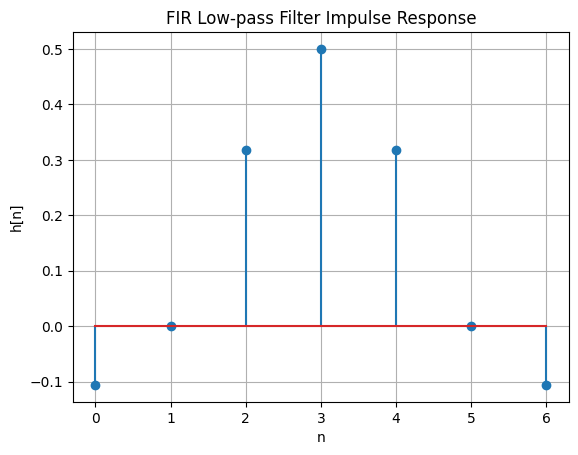

In [8]:
import numpy as np
import matplotlib.pyplot as plt

wc = np.pi / 2
N = 7
n = np.arange(N)
r = (N - 1) / 2

h = (wc / np.pi) * np.sinc((wc / np.pi) * (n - r))

plt.stem(n, h)
plt.title("FIR Low-pass Filter Impulse Response")
plt.xlabel("n")
plt.ylabel("h[n]")
plt.grid(True)
plt.show()

Now to do the filtering we'll just use a simple convolve method from numpy library.

In [9]:
FIR1_left = np.convolve(signal3_left , h , mode = 'same')
FIR1_right = np.convolve(signal3_right , h , mode = 'same')

#### 3.FIR low-pass filter2

$$
h[n] = 
\begin{cases}
\dfrac{\omega_c}{\pi} \cdot \text{sinc}\left( \dfrac{\omega_c(n)}{\pi} \right), & 0 \leq n < 7 \\
0, & \text{otherwise}
\end{cases}
$$

The implementation is the same

In [10]:
h = (wc / np.pi) * np.sinc((wc / np.pi) * (n))
FIR2_left = np.convolve(signal3_left , h , mode = 'same')
FIR2_right = np.convolve(signal3_right , h , mode = 'same')

#### 4. IIR Filter

lets first implement the difference equation.

From the transfer function:

$$
H(z) = \frac{1}{(1 - 0.9z^{-1})^2}
$$

This is a **cascaded** version of:

$$
H(z) = \frac{1}{1 - 0.9z^{-1}} \cdot \frac{1}{1 - 0.9z^{-1}}
$$

Which is a double pole at \( z = 0.9 \). This corresponds to the **difference equation**:

$$
y[n] = 1.8y[n-1] - 0.81y[n-2] + x[n]
$$

In [11]:
def iir_filter(x):
    x = np.asarray(x, dtype=np.float64)
    y = np.zeros_like(x, dtype=np.float64)
    for n in range(len(x)):
        y[n] = x[n]
        if n >= 1:
            y[n] += 1.8 * y[n - 1]
        if n >= 2:
            y[n] -= 0.81 * y[n - 2]
    return y

iir_right = iir_filter(signal3_right)
iir_left = iir_filter(signal3_left)
# (overflow was handled by converting signals to 64bit float)

Now let's implement the convolution.<br>
in order to do that we first have to convert $H(z)$ to "time" domain<br>
#### Calcalating $h[n]$

$$
x[n] = 0.9^nu[n] \xrightarrow{Z} \frac{1}{1-0.9z^(-1)}
$$

$$
(n+1)x[n] \xrightarrow{Z} \frac{1}{(1-0.9z^(-1))^2}
$$
##### Therefore
$$
H(z) \xrightarrow{Z^{-1}} (n+1)0.9^nu[n]
$$

In [12]:
# first let's define h[n]

h = []

for n in range(20):
    h.append((n+1)*((0.9)**n))

# now let's convlolve h and our signal

iir_right2 = np.convolve(signal3_right , h , mode='same')
iir_left2 = np.convolve(signal3_left , h , mode='same')

#### 5. FFT

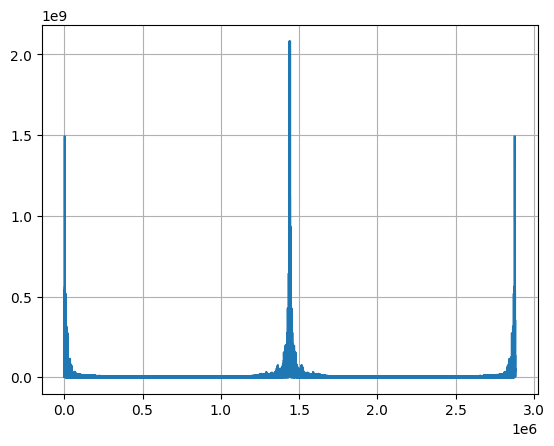

In [13]:
signal_fft_right = np.fft.fft(signal3_right)
plt.plot(np.abs(signal_fft_right))
plt.grid(True)
plt.show()

In [40]:
# let's filter our signal now
cutoff_idx = 200000  

signal_fft_right[cutoff_idx : -cutoff_idx] = 0 
# now we inverse

fft_filtered_signal = np.fft.ifft(signal_fft_right)

In [36]:
avg_signal_right.append(0)

### 1.3 Conclusion

first off let's see the norms.

In [41]:
print("Norm of signal1_right:", np.linalg.vector_norm(signal1_right))
print("Norm of avg_signal_right:", np.linalg.vector_norm(avg_signal_right))
print("Norm of FIR1_right:", np.linalg.vector_norm(FIR1_right))
print("Norm of FIR2_right:", np.linalg.vector_norm(FIR2_right))
print("Norm of iir_right:", np.linalg.vector_norm(iir_right))
print("Norm of iir_right2:", np.linalg.vector_norm(iir_right2))
print("Norm of fft_filtered_signal:", np.linalg.vector_norm(fft_filtered_signal))

Norm of signal1_right: 13005828.344360309
Norm of avg_signal_right: 11627549.510592936
Norm of FIR1_right: 8500660.86798566
Norm of FIR2_right: 7624664.369948254
Norm of iir_right: 845682280.3124324
Norm of iir_right2: 561079159.8256127
Norm of fft_filtered_signal: 9041242.268003136


In [42]:
def normalize_to_reference(reference_signal, target_signal):
    reference_signal = np.array(reference_signal)
    target_signal = np.array(target_signal)
    
    ref_norm = np.linalg.norm(reference_signal)
    target_norm = np.linalg.norm(target_signal)
    
    if target_norm == 0:
        return target_signal  # Avoid division by zero
    
    return target_signal * (ref_norm / target_norm)


def calculate_mse(signal1, signal2):
    return np.mean((signal1 - signal2) ** 2)

other_signals = {
    "avg_signal_right": avg_signal_right,
    "FIR1_right": FIR1_right,
    "FIR2_right": FIR2_right,
    "iir_right": iir_right,
    "iir_right2": iir_right2,
    "fft_filtered_signal": fft_filtered_signal
}

# Normalize all signals to have the same norm as signal1_right
normalized_signals = {}
for name, signal in other_signals.items():
    normalized_signals[name] = normalize_to_reference(signal1_right, signal)

# Calculate MSE between signal1_right and each normalized signal
mse_results = {}
for name, signal in normalized_signals.items():
    mse_results[name] = calculate_mse(signal1_right, signal)

# Print MSE results
print("Mean Squared Errors (MSE) between signal1_right and other signals:")
for name, mse in mse_results.items():
    print(f"{name}: {mse:.6f}")

Mean Squared Errors (MSE) between signal1_right and other signals:
avg_signal_right: 190214121.509260
FIR1_right: 105173670.360571
FIR2_right: 158422763.816321
iir_right: 117019451.065210
iir_right2: 115126873.462912
fft_filtered_signal: 117491865.342011+0.027594j


Seems like that the FIR1 filter has the least MSE error.

### 1.4 Implementing Block convolution for real time calculation using the Overlap-Add method

In [15]:
def overlap_add(input_signal, impulse_response, block_size):
    
    #initializing the signals
    x = np.asarray(input_signal)
    h = np.asarray(impulse_response)
    M = len(h)

    #block calcualtion params
    L = block_size
    N = L + M - 1 
    H = np.fft.fft(h, N) 

    #padding the signal
    x_padded = np.append(x, np.zeros(L - (len(x) % L)) if len(x) % L != 0 else [])
    
    output = np.zeros(len(x_padded) + M - 1)

    for i in range(0, len(x_padded), L):
        x_block = x_padded[i:i+L]
        x_block_padded = np.zeros(N)
        x_block_padded[:len(x_block)] = x_block
        
        #fft , mult , ifft
        X_block = np.fft.fft(x_block_padded)
        Y_block = X_block * H
        y_block = np.real(np.fft.ifft(Y_block))

        output[i:i+N] += y_block

    return output[:len(x) + M - 1]


In [16]:
iir_filter_overlap_add = overlap_add(signal3_right , h , 32)

## Section 2 - Estimating alpha parameter using PSD

### 2.1 Implementing the estimator method

In [62]:
import scipy.optimize 

def estimate_alpha(y):
    N = len(y)
    
    # 1. Compute empirical power spectrum (single realization)
    Py_empirical = np.abs(np.fft.fft(y))**2 / N
    freqs = np.fft.fftfreq(N)
    
    # 2. Theoretical power spectrum model
    def theoretical_spectrum(alpha, omega):
        return (1) / np.abs(1 - alpha * np.exp(-1j * omega))**2
    
    # 3. Error function to minimize
    def error_function(alpha):
        omega = 2 * np.pi * freqs[freqs >= 0]  # Positive frequencies
        Py_theo = theoretical_spectrum(alpha, omega)
        return np.sum(np.abs(Py_empirical[:len(omega)] - Py_theo)**r)
    
    # 4. Optimize using bounded method
    result = scipy.optimize.minimize_scalar(error_function, bounds=(-0.99, 0.99), method='bounded')
    alpha_hat = result.x
    
    return alpha_hat

### 2.2 Testing for $\alpha = {0.1 , 0.5}$

In [72]:
a = [0.1, 0.5]
N = 1024

for alpha in a:
    x = np.random.normal(0, 1, N)
    y = np.zeros(N)
    y[0] = x[0]
    for n in range(1, N):
        y[n] = alpha * y[n-1] + x[n]
    print(estimate_alpha(y))


0.14331713924932074
0.5712628109505947


looks close enough!

## Section 3 : $Laplace$ vs $Z$

### 3.1.1 plotting the impulse response and calculating the poles

Partial fraction expansion results:
Residues (r): [-2.17599961+0.j          1.58799981-0.14092967j  1.58799981+0.14092967j]
Poles (p): [-0.09558177+0.j         -0.40220911+0.60111572j -0.40220911-0.60111572j]
Direct term (k): []


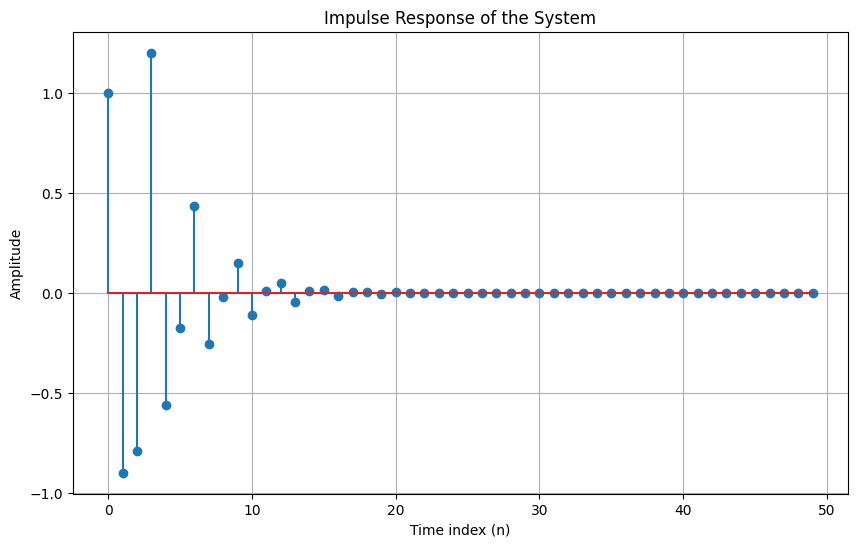

In [76]:
from scipy import signal

numerator = [1, 0, -1]
denominator = [1, 0.9, 0.6, 0.05]

r, p, k = signal.residuez(numerator, denominator)

print("Partial fraction expansion results:")
print("Residues (r):", r)
print("Poles (p):", p)
print("Direct term (k):", k)

n = np.arange(0, 50)
h = np.zeros_like(n, dtype=complex)

for i in range(len(r)):
    h += r[i] * (p[i] ** n)

h = h.real

plt.figure(figsize=(10, 6))
plt.stem(n, h)
plt.title('Impulse Response of the System')
plt.xlabel('Time index (n)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### 3.1.2 Checking the Stability of the System

In [77]:
# Print pole information
print("\nPole information:")
for i, pole in enumerate(p):
    magnitude = np.abs(pole)
    angle = np.angle(pole) * 180 / np.pi  # in degrees
    print(f"Pole {i+1}:")
    print(f"  Value: {pole:.4f}")
    print(f"  Magnitude: {magnitude:.4f}")
    print(f"  Angle: {angle:.4f}°")
    if magnitude > 1:
        print("  This pole is OUTSIDE the unit circle (unstable)")
    elif magnitude == 1:
        print("  This pole is ON the unit circle (marginally stable)")
    else:
        print("  This pole is INSIDE the unit circle (stable)")


Pole information:
Pole 1:
  Value: -0.0956+0.0000j
  Magnitude: 0.0956
  Angle: 180.0000°
  This pole is INSIDE the unit circle (stable)
Pole 2:
  Value: -0.4022+0.6011j
  Magnitude: 0.7233
  Angle: 123.7867°
  This pole is INSIDE the unit circle (stable)
Pole 3:
  Value: -0.4022-0.6011j
  Magnitude: 0.7233
  Angle: -123.7867°
  This pole is INSIDE the unit circle (stable)


it's evident that all the poles are stable because they all lie inside the unit circle as it can be seen below (and above :D )

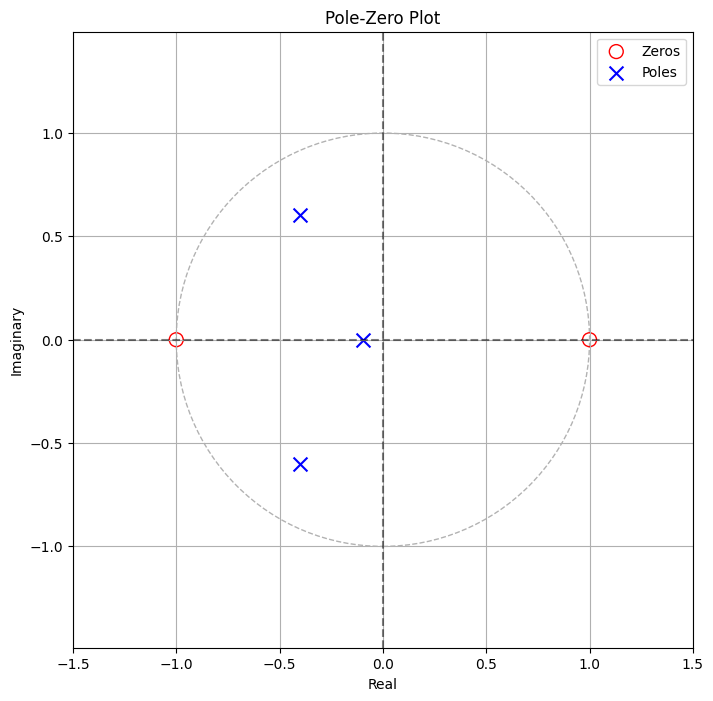

In [78]:
zeros = np.roots(numerator)
poles = np.roots(denominator)

plt.figure(figsize=(8, 8))

circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--', alpha=0.3)
plt.gca().add_patch(circle)

plt.scatter(np.real(zeros), np.imag(zeros), marker='o', facecolors='none', edgecolors='r', s=100, label='Zeros')
plt.scatter(np.real(poles), np.imag(poles), marker='x', color='b', s=100, label='Poles')

plt.axhline(0, color='black', alpha=0.5, linestyle='--')
plt.axvline(0, color='black', alpha=0.5, linestyle='--')
plt.title('Pole-Zero Plot')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.show()

### 3.1.3 Varying a parameter of $H(z)$ and plotting impulse response and pole placement

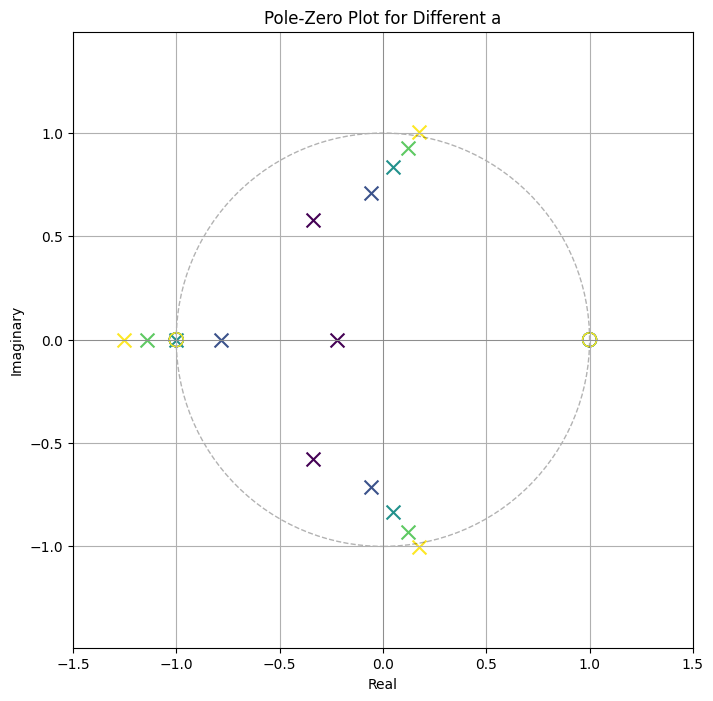

In [86]:
A = np.arange(0.1 , 1.5 , 0.3) 
colors = plt.cm.viridis(np.linspace(0, 1, len(A)))  # Use a colormap for variety

plt.figure(figsize=(8, 8))

for idx, a in enumerate(A):
    numerator = [1, 0, -1]
    denominator = [1, 0.9, 0.6, a]

    zeros = np.roots(numerator)
    poles = np.roots(denominator)

    # Plot zeros and poles with varied colors
    plt.scatter(np.real(zeros), np.imag(zeros),
                marker='o', facecolors='none', edgecolors=colors[idx],
                s=100, label=f'Zeros (a={a})')

    plt.scatter(np.real(poles), np.imag(poles),
                marker='x', color=colors[idx], s=100, label=f'Poles (a={a})')

circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--', alpha=0.3)

plt.gca().add_patch(circle)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Pole-Zero Plot for Different a')
plt.grid(True)
#plt.legend()
plt.axis('equal')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.show()
    

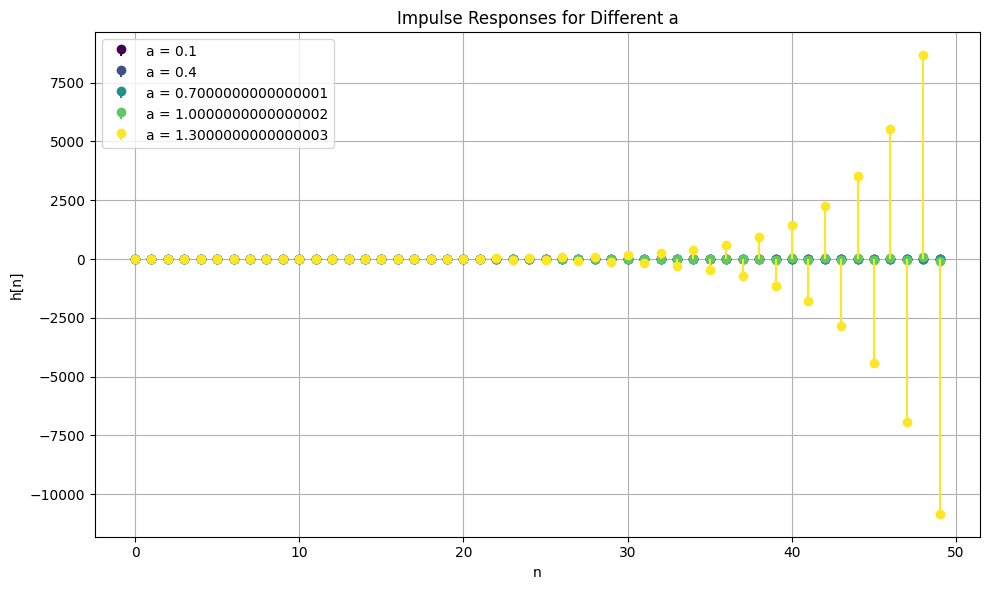

In [89]:
A = np.arange(0.1, 1.5, 0.3)
colors = plt.cm.viridis(np.linspace(0, 1, len(A)))

plt.figure(figsize=(10, 6))
n = np.arange(0, 50)

for idx, a in enumerate(A):
    numerator = [1, 0, -1]
    denominator = [1, 0.9, 0.6, a]
    r, p, k = signal.residuez(numerator, denominator)
    
    h = np.zeros_like(n, dtype=complex)
    for i in range(len(r)):
        h += r[i] * (p[i] ** n)
    h = h.real

    markerline, stemlines, baseline = plt.stem(n, h, basefmt=" ", label=f'a = {a}')
    plt.setp(markerline, color=colors[idx])
    plt.setp(stemlines, color=colors[idx])

plt.xlabel('n')
plt.ylabel('h[n]')
plt.title('Impulse Responses for Different a')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



as it's shown above choosing $a = 1.3$ makes the System unstable , the effect is seen on $h[n]$ too (it makes it unbounded)

### 3.1.4 Plotting the frequency response of the System

C:\Users\darkoob\AppData\Local\Temp\ipykernel_5736\3848853621.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freq, 20 * np.log10(np.abs(h)))


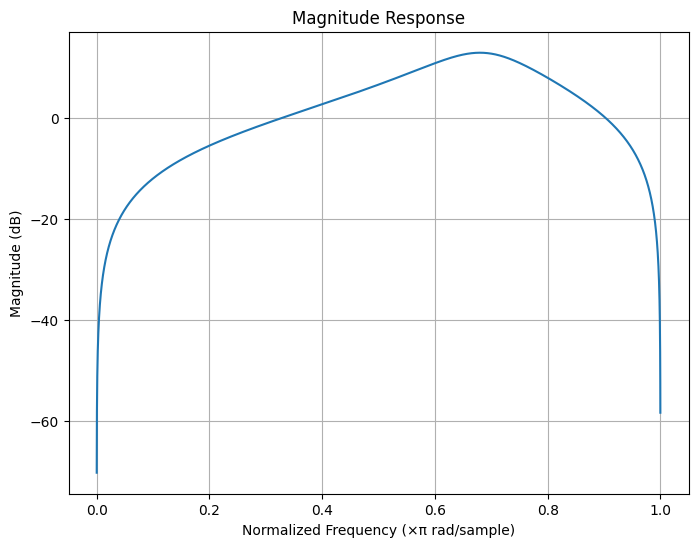

In [96]:
numerator = [1, 0, -1]
denominator = [1, 0.9, 0.6, 0.05]

w, h = signal.freqz(numerator, denominator, worN=8000)

freq = w / np.pi

plt.figure(figsize=(8, 6))
plt.plot(freq, 20 * np.log10(np.abs(h)))
plt.title('Magnitude Response')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

As it can be seen from the plot above , the filter is a bandpass filter. <br>
it doesn't pass low and high frequencys but it passes the middle frequencies.

### 3.1.5 Rebuilding the system based on the zeroes and poles

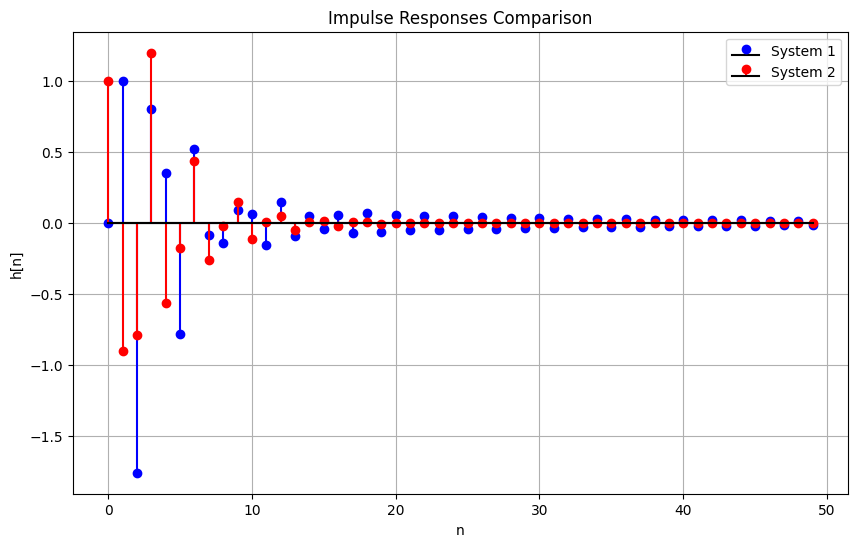

In [110]:
numerator1 = [1, 0, -1]
denominator1 = np.poly([-0.956, -0.4022 + 0.6011j, -0.4022 - 0.6011j])
n = np.arange(0, 50)
_, h1 = signal.dimpulse((numerator1, denominator1, 1), n=len(n))

numerator2 = [1, 0, -1]
denominator2 = [1, 0.9, 0.6, 0.05]
r, p, k = signal.residuez(numerator2, denominator2)
h2 = np.zeros_like(n, dtype=complex)
for i in range(len(r)):
    h2 += r[i] * (p[i] ** n)
h2 = h2.real

plt.figure(figsize=(10, 6))
plt.stem(n, h1[0].squeeze(), linefmt='b-', markerfmt='bo', basefmt='k-', label='System 1')
plt.stem(n, h2, linefmt='r-', markerfmt='ro', basefmt='k-', label='System 2')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.title('Impulse Responses Comparison')
plt.grid(True)
plt.legend()
plt.show()

the impulse responses aren't "quite" the same because our trasfer function isn't quite the same as the original one because we're ignoring the poles as 0.

## 3.2 Laplace

### 3.2.1.1 Calculating some responses of the System : $$H_1(s) = \frac{3s + 4}{s^2 + 5s + 6}$$

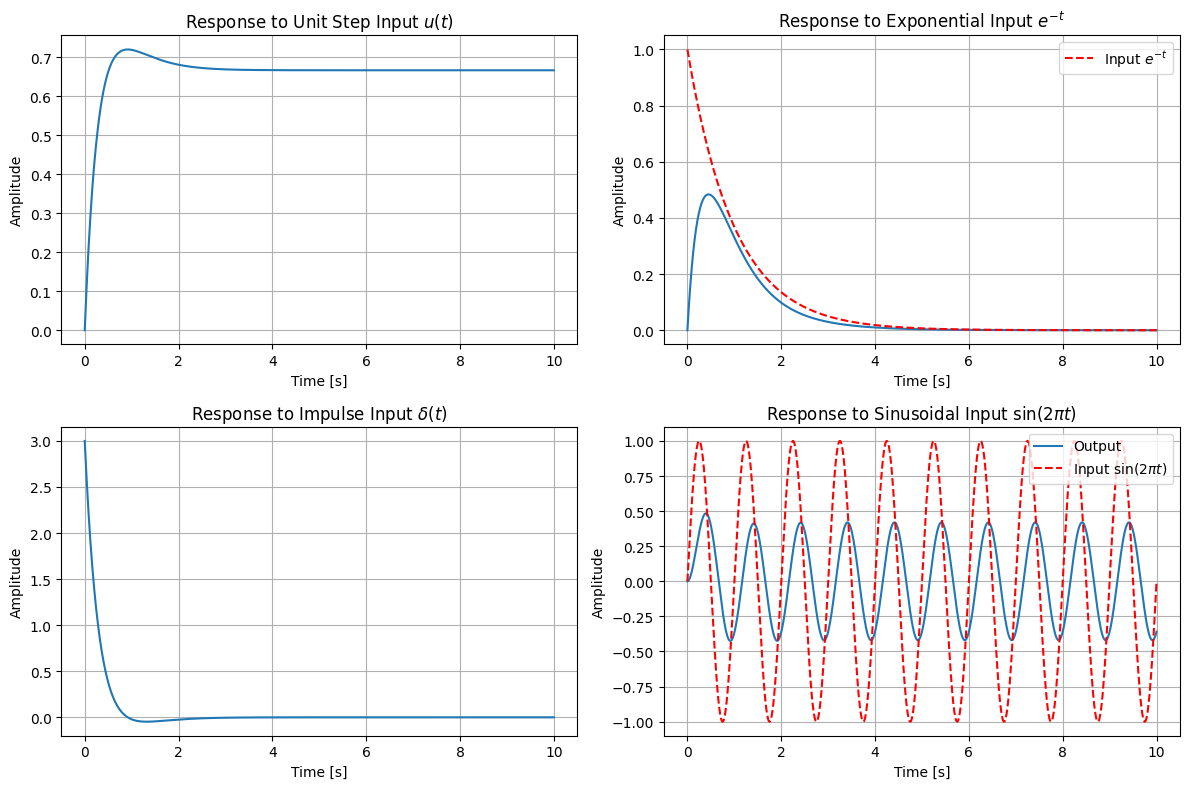

In [1]:
numerator = [3, 4]  
denominator = [1, 5, 6]
sys = signal.TransferFunction(numerator, denominator)

t = np.linspace(0, 10, 1000)

plt.figure(figsize=(12, 8))

## 1. Unit Step Response
plt.subplot(2, 2, 1)
t_step, y_step = signal.step(sys, T=t)
plt.plot(t_step, y_step)
plt.title('Response to Unit Step Input $u(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

## 2. Response to Exponential Input e^(-t)
t_exp = t
u_exp = np.exp(-t_exp)
t_exp, y_exp, _ = signal.lsim(sys, u_exp, t_exp)
plt.subplot(2, 2, 2)
plt.plot(t_exp, y_exp)
plt.plot(t_exp, u_exp, 'r--', label='Input $e^{-t}$')
plt.title('Response to Exponential Input $e^{-t}$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

## 3. Impulse Response
plt.subplot(2, 2, 3)
t_impulse, y_impulse = signal.impulse(sys, T=t)
plt.plot(t_impulse, y_impulse)
plt.title('Response to Impulse Input $\delta(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

## 4. Response to Sinusoidal Input sin(2πt)
t_sin = t
u_sin = np.sin(2 * np.pi * t_sin)
t_sin, y_sin, _ = signal.lsim(sys, u_sin, t_sin)
plt.subplot(2, 2, 4)
plt.plot(t_sin, y_sin, label='Output')
plt.plot(t_sin, u_sin, 'r--', label='Input $\sin(2\pi t)$')
plt.title('Response to Sinusoidal Input $\sin(2\pi t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### 3.2.1.2 Calculating some responses of the System : $$H_2(s) = \frac{2s + 5}{s^2 + 6s + 9}$$

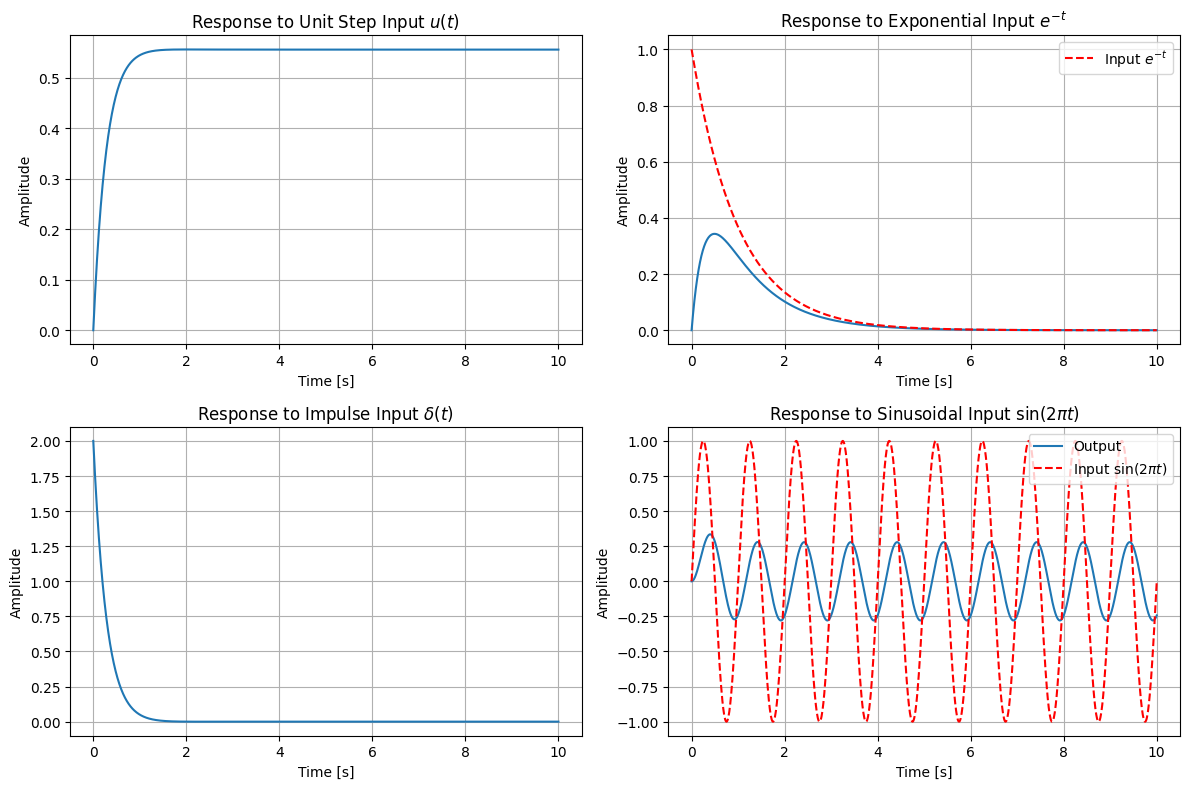

In [3]:
numerator = [2, 5]  
denominator = [1, 6, 9]
sys = signal.TransferFunction(numerator, denominator)

t = np.linspace(0, 10, 1000)

plt.figure(figsize=(12, 8))

## 1. Unit Step Response
plt.subplot(2, 2, 1)
t_step, y_step = signal.step(sys, T=t)
plt.plot(t_step, y_step)
plt.title('Response to Unit Step Input $u(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

## 2. Response to Exponential Input e^(-t)
t_exp = t
u_exp = np.exp(-t_exp)
t_exp, y_exp, _ = signal.lsim(sys, u_exp, t_exp)
plt.subplot(2, 2, 2)
plt.plot(t_exp, y_exp)
plt.plot(t_exp, u_exp, 'r--', label='Input $e^{-t}$')
plt.title('Response to Exponential Input $e^{-t}$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

## 3. Impulse Response
plt.subplot(2, 2, 3)
t_impulse, y_impulse = signal.impulse(sys, T=t)
plt.plot(t_impulse, y_impulse)
plt.title('Response to Impulse Input $\delta(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

## 4. Response to Sinusoidal Input sin(2πt)
t_sin = t
u_sin = np.sin(2 * np.pi * t_sin)
t_sin, y_sin, _ = signal.lsim(sys, u_sin, t_sin)
plt.subplot(2, 2, 4)
plt.plot(t_sin, y_sin, label='Output')
plt.plot(t_sin, u_sin, 'r--', label='Input $\sin(2\pi t)$')
plt.title('Response to Sinusoidal Input $\sin(2\pi t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### 3.2.1.3 Calculating some responses of the System : $$H_3(s) = \frac{1}{s^2 + 4s + 5}$$

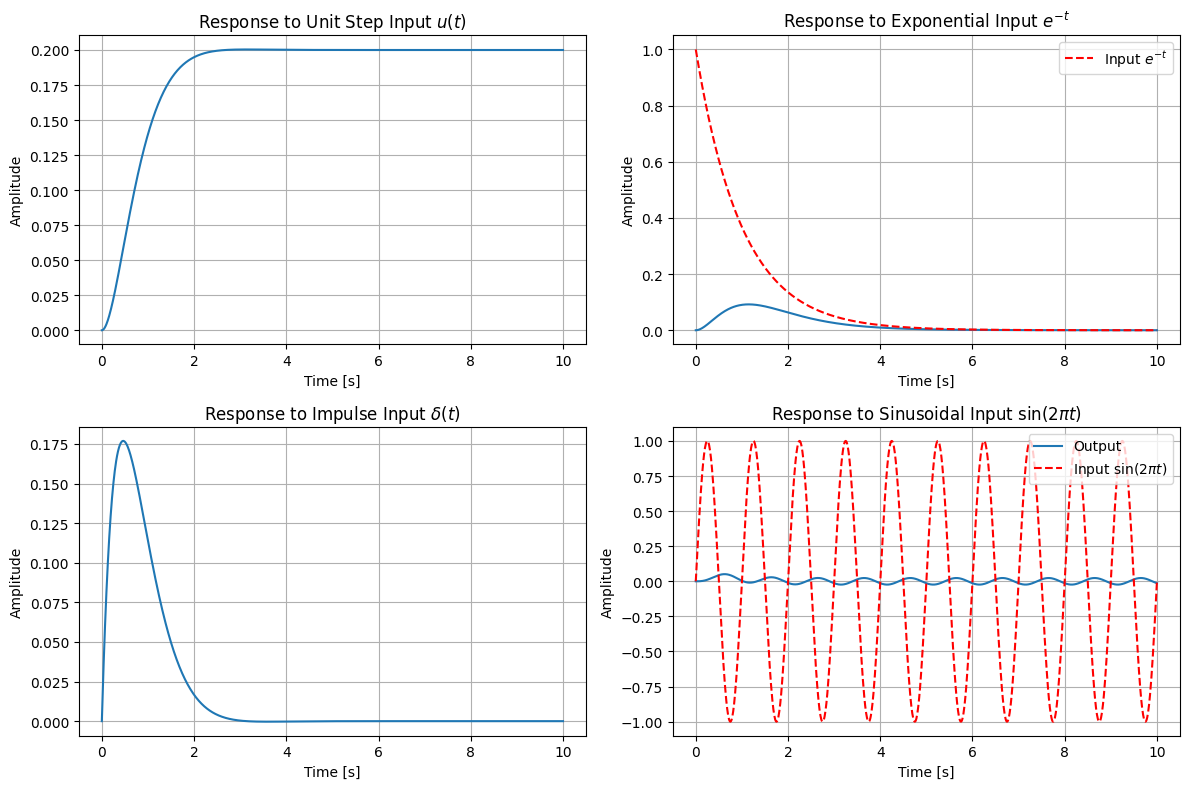

In [4]:
numerator = [1]  
denominator = [1, 4, 5]
sys = signal.TransferFunction(numerator, denominator)

t = np.linspace(0, 10, 1000)

plt.figure(figsize=(12, 8))

## 1. Unit Step Response
plt.subplot(2, 2, 1)
t_step, y_step = signal.step(sys, T=t)
plt.plot(t_step, y_step)
plt.title('Response to Unit Step Input $u(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

## 2. Response to Exponential Input e^(-t)
t_exp = t
u_exp = np.exp(-t_exp)
t_exp, y_exp, _ = signal.lsim(sys, u_exp, t_exp)
plt.subplot(2, 2, 2)
plt.plot(t_exp, y_exp)
plt.plot(t_exp, u_exp, 'r--', label='Input $e^{-t}$')
plt.title('Response to Exponential Input $e^{-t}$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

## 3. Impulse Response
plt.subplot(2, 2, 3)
t_impulse, y_impulse = signal.impulse(sys, T=t)
plt.plot(t_impulse, y_impulse)
plt.title('Response to Impulse Input $\delta(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

## 4. Response to Sinusoidal Input sin(2πt)
t_sin = t
u_sin = np.sin(2 * np.pi * t_sin)
t_sin, y_sin, _ = signal.lsim(sys, u_sin, t_sin)
plt.subplot(2, 2, 4)
plt.plot(t_sin, y_sin, label='Output')
plt.plot(t_sin, u_sin, 'r--', label='Input $\sin(2\pi t)$')
plt.title('Response to Sinusoidal Input $\sin(2\pi t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### Inspecting the decay of responses of the system
to answer the question which of the systems reaches steady state faster , it's evident that $H_3(s)$ reaches steady state faster in all the cases.

### 3.2.2 finding the poles

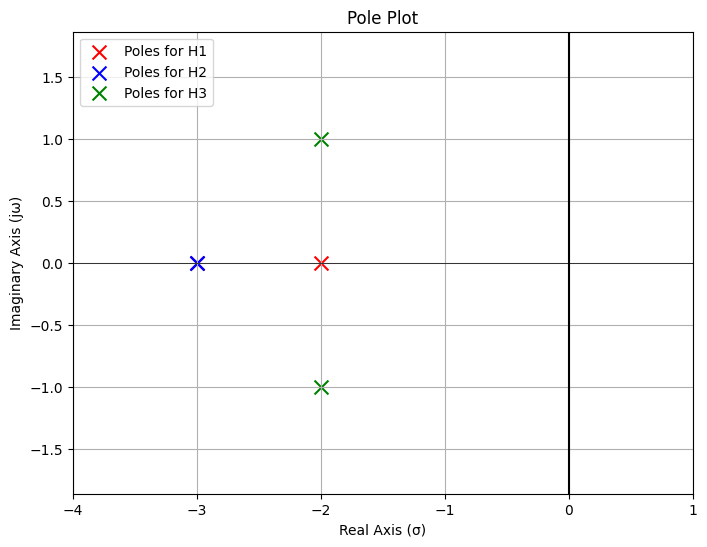

In [18]:
numerator1 = [3, 4]
denominator1 = [1, 5, 6]

numerator2 = [2, 5]
denominator2 = [1, 6, 9]

numerator3 = [1]
denominator3 = [1, 4, 5]

sys1 = signal.TransferFunction(numerator1, denominator1)
sys2 = signal.TransferFunction(numerator2, denominator2)
sys3 = signal.TransferFunction(numerator3, denominator3)


# Get poles and zeros
poles1 = sys1.poles
poles2 = sys2.poles
poles3 = sys3.poles


plt.figure(figsize=(8, 6))

plt.scatter(np.real(poles1), np.imag(poles1), marker='x', color='red', s=100, label='Poles for H1')
plt.scatter(np.real(poles2), np.imag(poles2), marker='x', color='blue', s=100, label='Poles for H2')
plt.scatter(np.real(poles3), np.imag(poles3), marker='x', color='green', s=100, label='Poles for H3')


plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.title('Pole Plot')
plt.xlabel('Real Axis (σ)')
plt.ylabel('Imaginary Axis (jω)')
plt.grid(True)
plt.axis('equal')
plt.xlim([-4, 1])
plt.ylim([-2, 2])
plt.legend()
plt.show()

All poles are at the left side of the $j\omega$ axis therefore all the Systems are "**Stable**"

### 3.2.3 Bode Plot

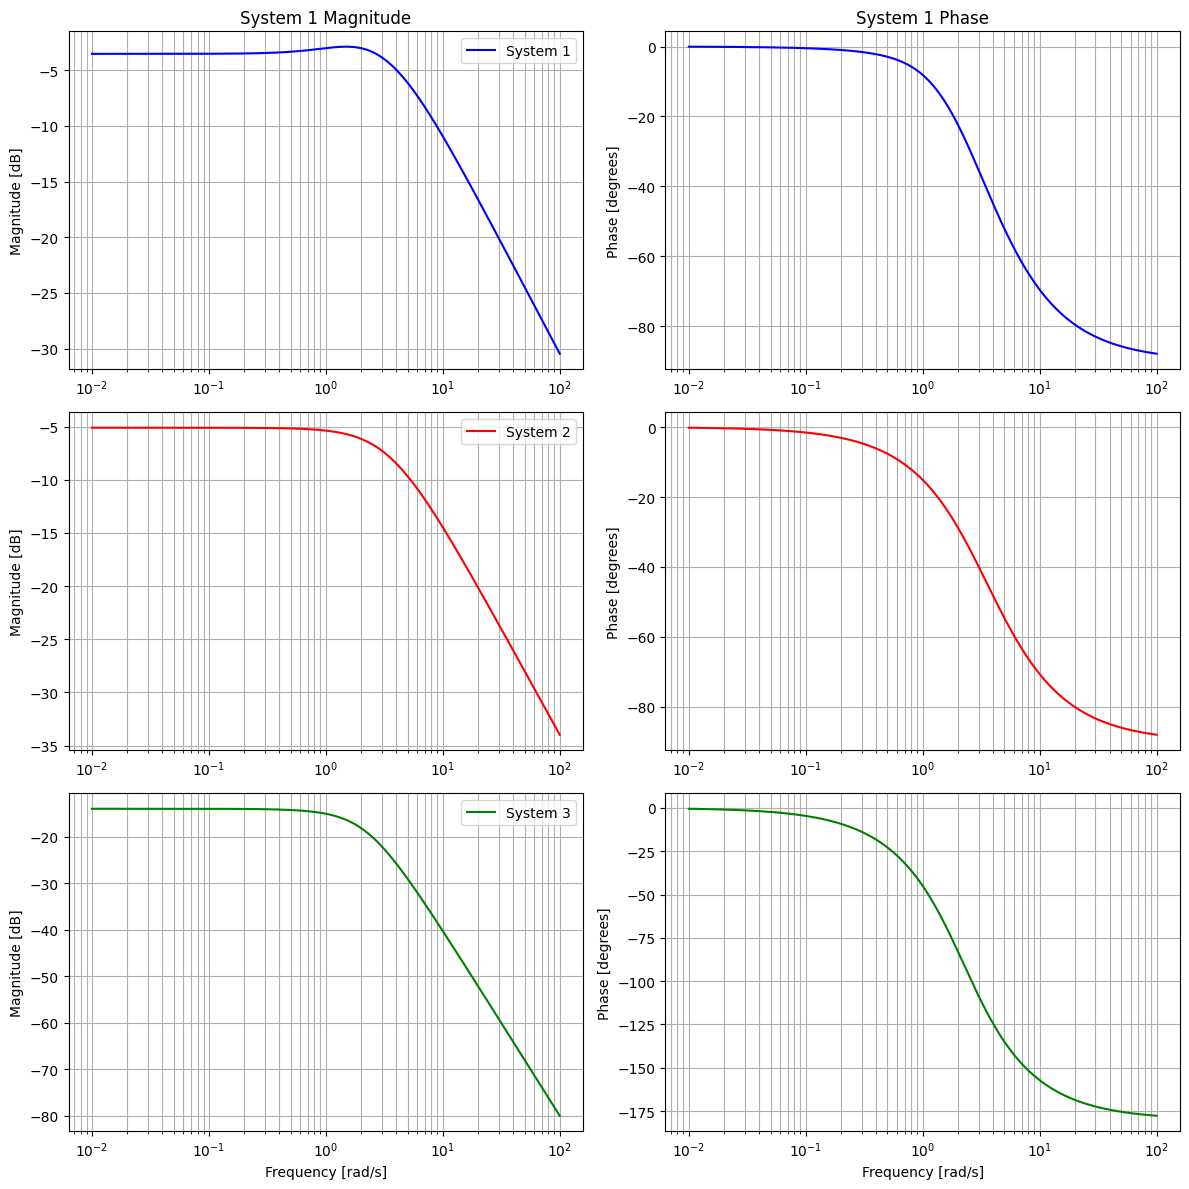

In [10]:
numerator1 = [3, 4]
denominator1 = [1, 5, 6]
numerator2 = [2, 5]
denominator2 = [1, 6, 9]
numerator3 = [1]
denominator3 = [1, 4, 5]

sys1 = signal.TransferFunction(numerator1, denominator1)
sys2 = signal.TransferFunction(numerator2, denominator2)
sys3 = signal.TransferFunction(numerator3, denominator3)

# Frequency range
w = np.logspace(-2, 2, 500)
w, mag1, phase1 = signal.bode(sys1, w)
w, mag2, phase2 = signal.bode(sys2, w)
w, mag3, phase3 = signal.bode(sys3, w)

# Create the figure with 3 rows (systems) and 2 columns (mag/phase)
plt.figure(figsize=(12, 12))

# System 1
plt.subplot(3, 2, 1)
plt.semilogx(w, mag1, 'b', label='System 1')
plt.title('System 1 Magnitude')
plt.ylabel('Magnitude [dB]')
plt.grid(which='both', axis='both')
plt.legend()

plt.subplot(3, 2, 2)
plt.semilogx(w, phase1, 'b')
plt.title('System 1 Phase')
plt.ylabel('Phase [degrees]')
plt.grid(which='both', axis='both')

# System 2
plt.subplot(3, 2, 3)
plt.semilogx(w, mag2, 'r', label='System 2')
plt.ylabel('Magnitude [dB]')
plt.grid(which='both', axis='both')
plt.legend()

plt.subplot(3, 2, 4)
plt.semilogx(w, phase2, 'r')
plt.ylabel('Phase [degrees]')
plt.grid(which='both', axis='both')

# System 3
plt.subplot(3, 2, 5)
plt.semilogx(w, mag3, 'g', label='System 3')
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [rad/s]')
plt.grid(which='both', axis='both')
plt.legend()

plt.subplot(3, 2, 6)
plt.semilogx(w, phase3, 'g')
plt.ylabel('Phase [degrees]')
plt.xlabel('Frequency [rad/s]')
plt.grid(which='both', axis='both')

plt.tight_layout()
plt.show()

### 3.2.4 Plotting the systems responses to $X(t) = e^{-t} + \sin(2\pi t) + u(t)$

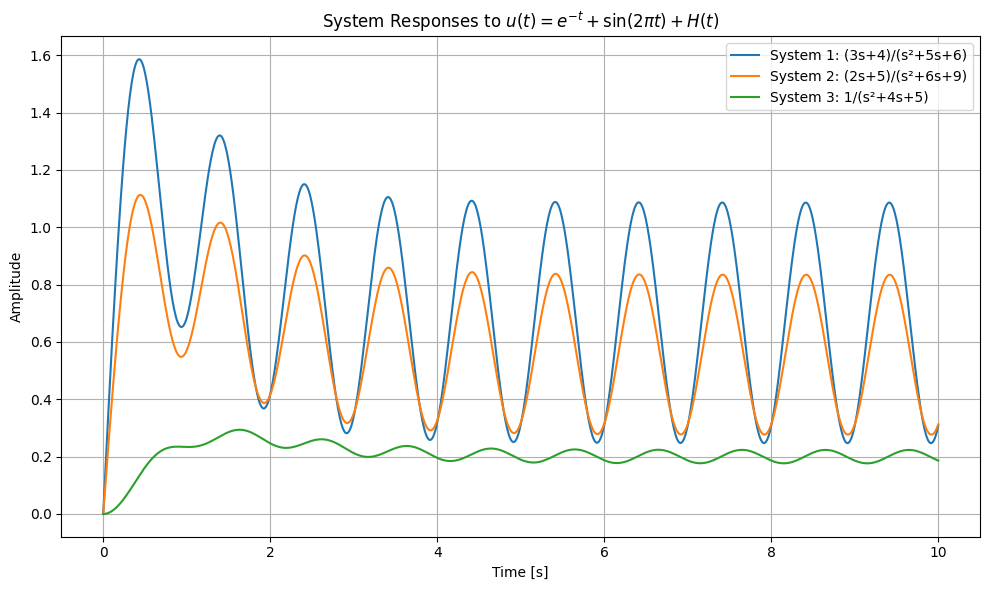

In [20]:
t = np.linspace(0, 10, 1000)
u = np.exp(-t) + np.sin(2*np.pi*t) + np.heaviside(t, 0.5)

t, y1, _ = signal.lsim(sys1, u, t)
t, y2, _ = signal.lsim(sys2, u, t)
t, y3, _ = signal.lsim(sys3, u, t)

plt.figure(figsize=(10, 6))
plt.plot(t, y1, label='System 1: (3s+4)/(s²+5s+6)')
plt.plot(t, y2, label='System 2: (2s+5)/(s²+6s+9)')
plt.plot(t, y3, label='System 3: 1/(s²+4s+5)')

plt.title('System Responses to $u(t) = e^{-t} + \sin(2\pi t) + H(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### 3.2.5 Varying the damping parameter $\zeta$ in $H_1(s)$ and plotting the step response

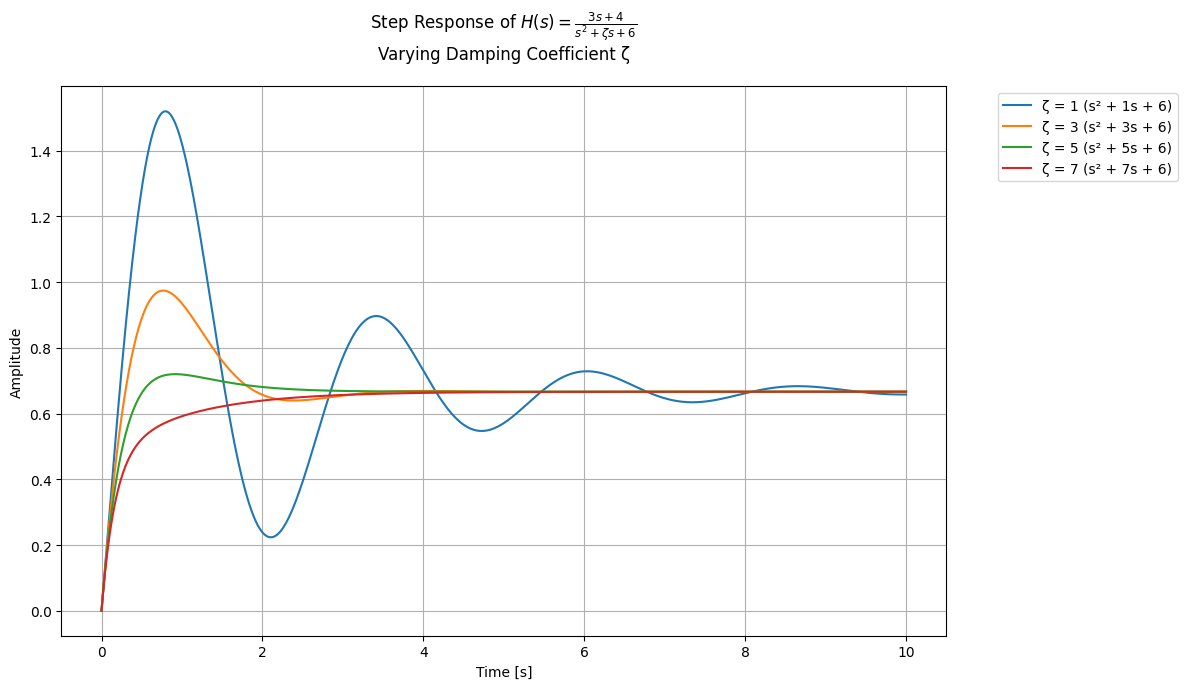

In [ ]:
# Fixed numerator
numerator = [3, 4]

# Denominator parameters
zeta_values = [1, 3, 5, 7]  # Different damping coefficients to test
omega_n_squared = 6

t = np.linspace(0, 10, 1000)

plt.figure(figsize=(12, 7))

for zeta in zeta_values:
    denominator = [1, zeta, omega_n_squared]
    sys = signal.TransferFunction(numerator, denominator)
    
    t_step, y_step = signal.step(sys, T=t)
    
    plt.plot(t_step, y_step, 
             label=f'ζ = {zeta} (s² + {zeta}s + {omega_n_squared})')

plt.title('Step Response of $H(s) = \\frac{3s + 4}{s^2 + ζs + 6}$\nVarying Damping Coefficient ζ', 
          pad=20)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

## Section 4 : a bit of Keypad!

### 4.1 Implementing the signal generating function 

In [8]:
from scipy.io.wavfile import write

def generate_dtmf_sequence(number, sample_rate=8000):
    dtmf_frequencies = {
        '1': (697, 1209), '2': (697, 1336), '3': (697, 1477), 'A': (697, 1633),
        '4': (770, 1209), '5': (770, 1336), '6': (770, 1477), 'B': (770, 1633),
        '7': (852, 1209), '8': (852, 1336), '9': (852, 1477), 'C': (852, 1633),
        '*': (941, 1209), '0': (941, 1336), '#': (941, 1477), 'D': (941, 1633)
    }
    
    # Convert input number to string and validate
    num_str = str(number)
    for char in num_str:
        if char not in dtmf_frequencies:
            raise ValueError(f"Invalid DTMF character: {char}")
    
    # Parameters
    tone_duration = 1000  # samples per digit
    silence_duration = 1000  # samples of silence
    total_samples = len(num_str) * (tone_duration + silence_duration)
    t = np.arange(total_samples) / sample_rate 
    
    signal = np.zeros(total_samples)
    
    # Generate signal
    for i, digit in enumerate(num_str):
        f1, f2 = dtmf_frequencies[digit]
        start_idx = i * (tone_duration + silence_duration)
        end_idx = start_idx + tone_duration
        
        # Generate tone
        tone_samples = np.arange(start_idx, end_idx)
        signal[start_idx:end_idx] = (
            0.5 * np.sin(2 * np.pi * f1 * tone_samples / sample_rate) +
            0.5 * np.sin(2 * np.pi * f2 * tone_samples / sample_rate))
    
    # Normalize and convert to 16-bit WAV format
    signal = np.int16(signal * 32767)
    
    return signal

student_id = generate_dtmf_sequence(402102302)
write('StudentID.wav', 8000, student_id)
student_id.shape

(18000,)

### 4.2 Analizing our sequence in frequncy domain

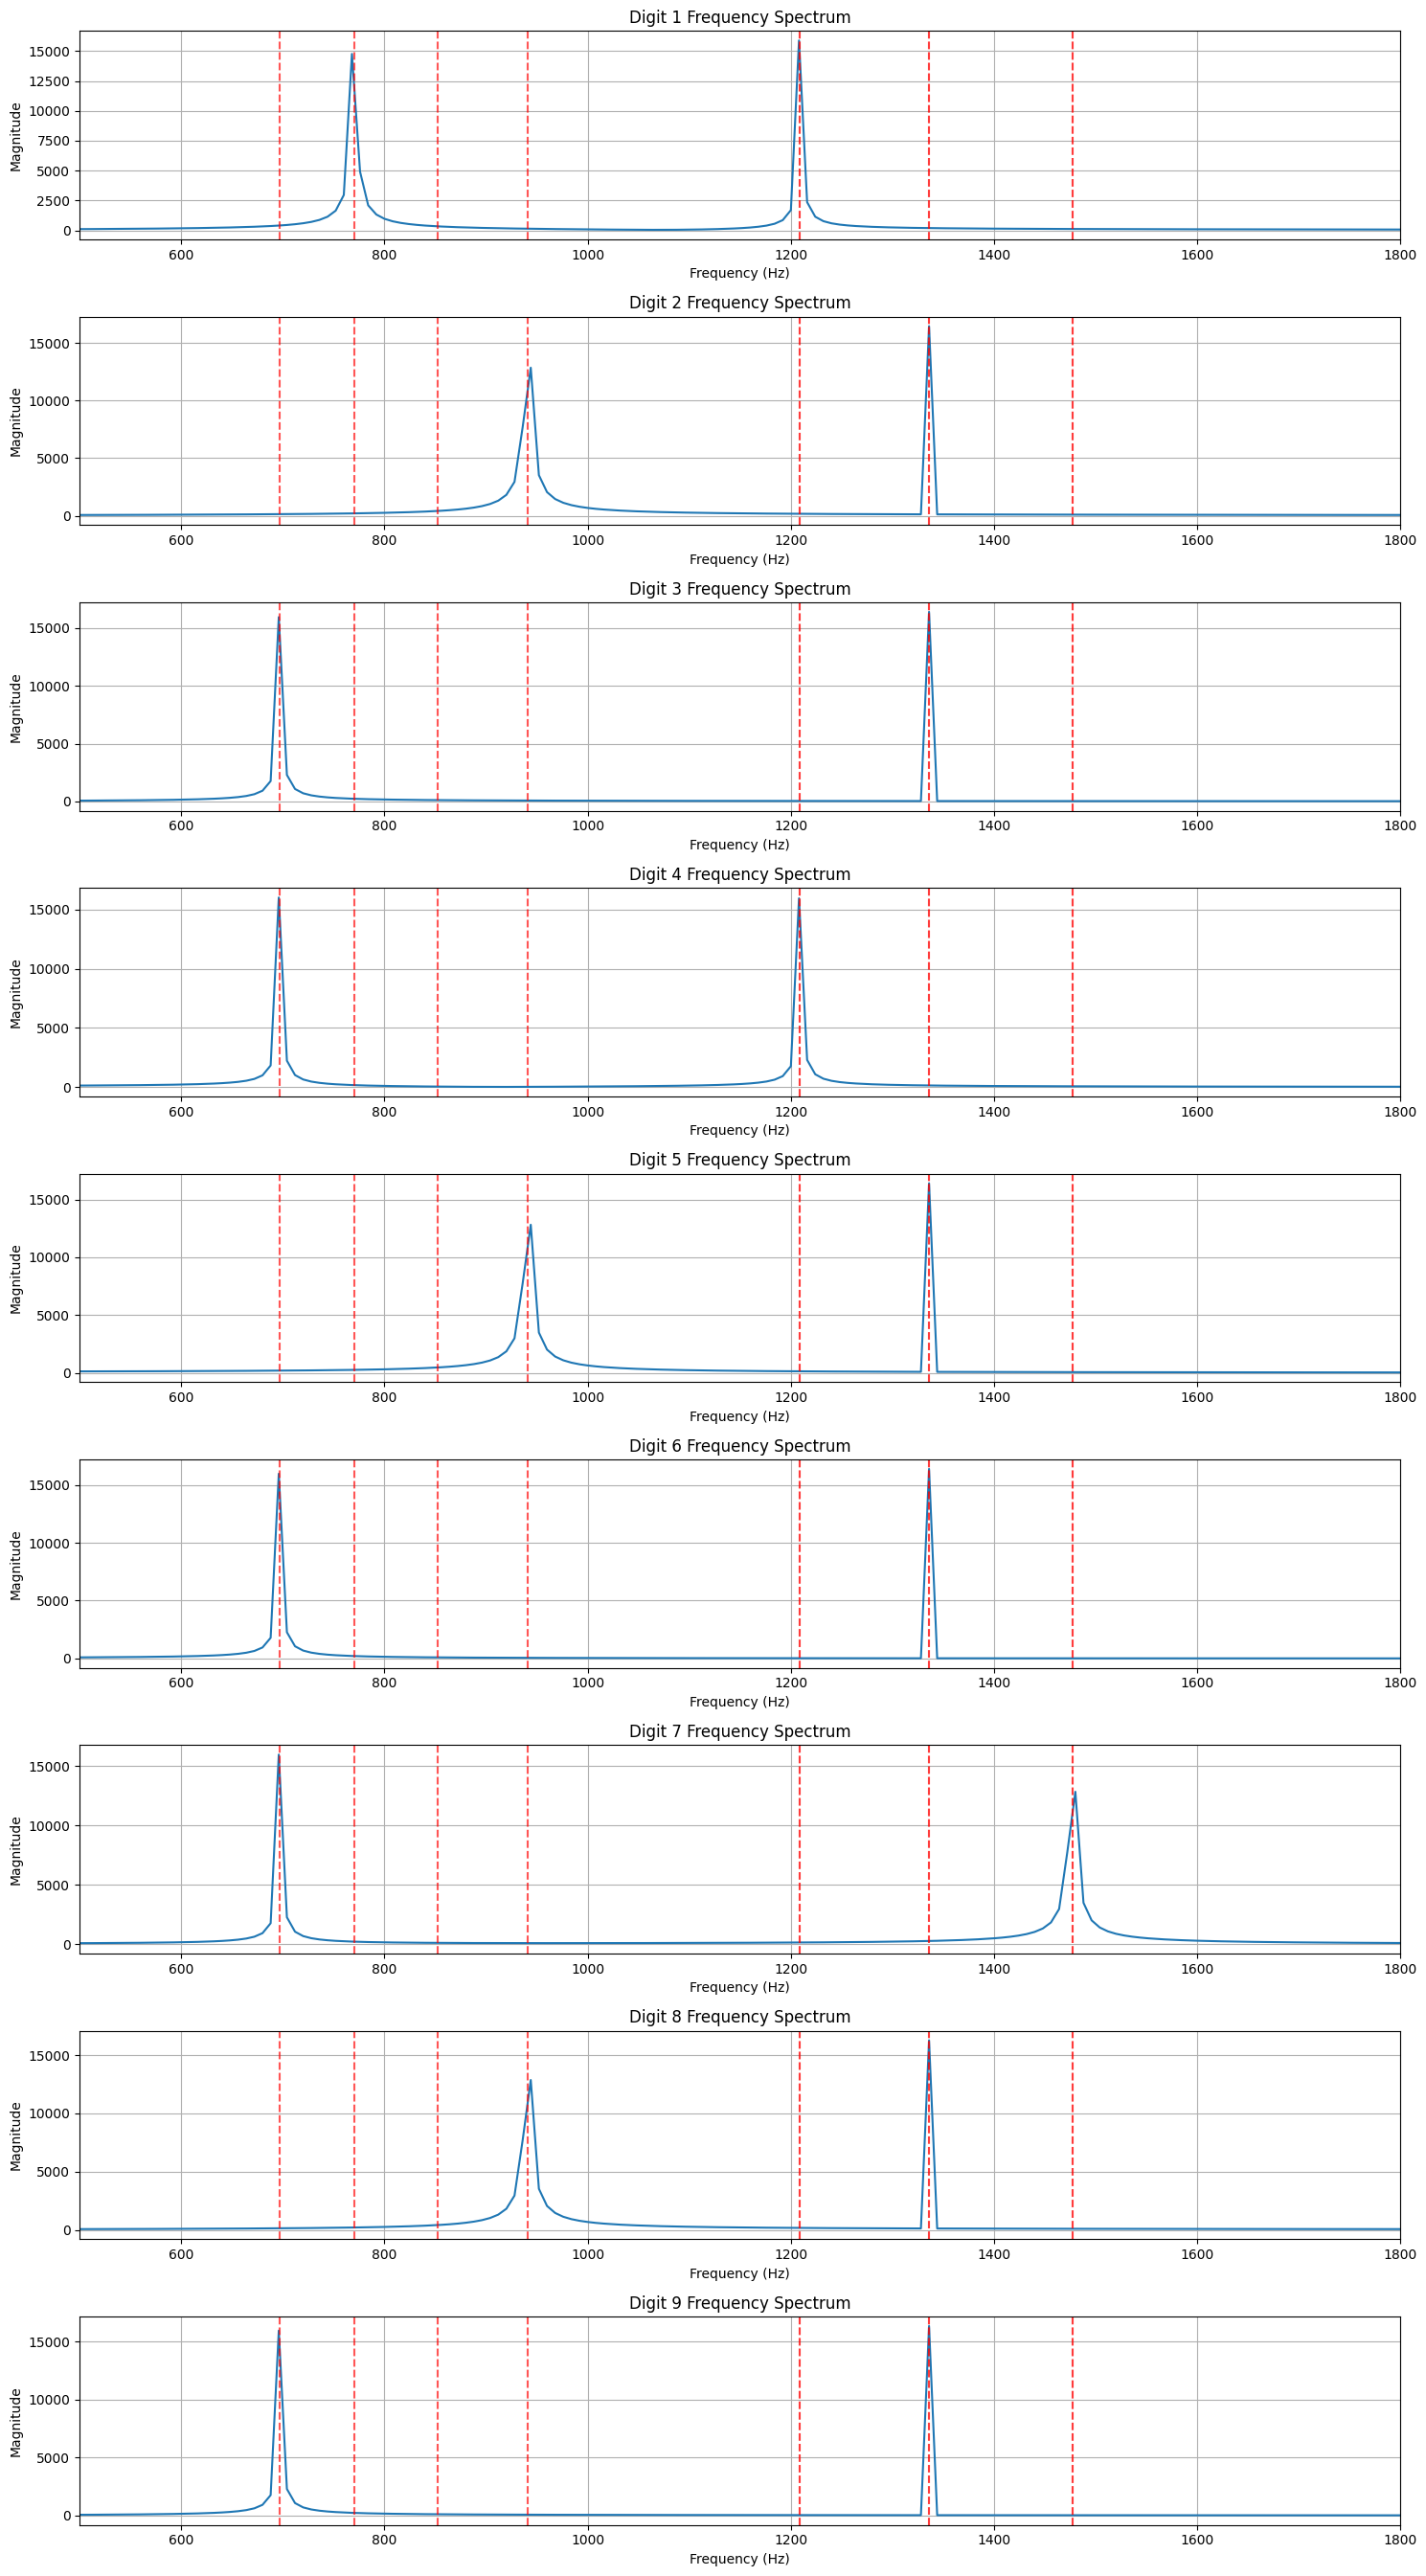

In [7]:
from scipy.fft import fft, fftfreq

def analyze_dtmf_sequence(signal, sample_rate=8000):
    tone_duration = 1000
    silence_duration = 1000
    segment_length = tone_duration + silence_duration
    
    num_digits = len(signal) // segment_length
    
    dtmf_freqs = {
        '1': (697, 1209), '2': (697, 1336), '3': (697, 1477),
        '4': (770, 1209), '5': (770, 1336), '6': (770, 1477),
        '7': (852, 1209), '8': (852, 1336), '9': (852, 1477),
        '*': (941, 1209), '0': (941, 1336), '#': (941, 1477)
    }
    
    plt.figure(figsize=(15, 3 * num_digits))
    
    for i in range(num_digits):
        start = i * segment_length
        end = start + tone_duration
        segment = signal[start:end]
        
        N = len(segment)
        yf = fft(segment)
        xf = fftfreq(N, 1 / sample_rate)[:N//2]
        
        plt.subplot(num_digits, 1, i+1)
        plt.plot(xf, 2/N * np.abs(yf[0:N//2]))
        plt.title(f'Digit {i+1} Frequency Spectrum')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid(True)
        
        for char, (f1, f2) in dtmf_freqs.items():
            plt.axvline(x=f1, color='r', linestyle='--', alpha=0.3)
            plt.axvline(x=f2, color='r', linestyle='--', alpha=0.3)
        
        plt.xlim([500, 1800])
    
    plt.tight_layout()
    plt.show()

analyze_dtmf_sequence(student_id)

### 4.3 Implementing a sequence detector

In [99]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, hilbert

def detect_dtmf_sequence(signal, sample_rate=8000, energy_threshold=0.05, min_tone_length=100, min_gap=100):
    """ 
    Code Explanation : 

    in this method , we first normalize our signal in order to extract the parts that aren't zero.
    we do an envelope detection using hilbert transform and then smooth out our signal to get rid of the noise.
    then we segment the parts where the signal is greater then our set treshold.
    after that its pretty straight forward , we perform fft on the segments , extract the peak frequencies and then we resort to our dtmf frequency dictionary
    to match our peak frequency to the corresponding integer

    """

    dtmf_frequencies = {
        (697, 1209): '1', (697, 1336): '2', (697, 1477): '3',
        (770, 1209): '4', (770, 1336): '5', (770, 1477): '6',
        (852, 1209): '7', (852, 1336): '8', (852, 1477): '9',
        (941, 1209): '*', (941, 1336): '0', (941, 1477): '#'
    }

    signal = signal.astype(np.float64)
    signal = signal / np.max(np.abs(signal))

    envelope = np.abs(hilbert(signal))
    smoothed = np.convolve(envelope, np.ones(100)/100, mode='same')

    is_tone = smoothed > energy_threshold
    tone_segments = []
    i = 0
    while i < len(is_tone):
        if is_tone[i]:
            start = i
            while i < len(is_tone) and is_tone[i]:
                i += 1
            end = i
            if end - start >= min_tone_length:
                tone_segments.append((start, end))
        else:
            i += 1

    detected_digits = []
    #print(f"Detected {len(tone_segments)} tone segments")

    for idx, (start, end) in enumerate(tone_segments):
        segment = signal[start:end]
        N = len(segment)
        yf = fft(segment)
        xf = fftfreq(N, 1/sample_rate)[:N//2]
        magnitude = 2/N * np.abs(yf[0:N//2])

        peaks, props = find_peaks(magnitude, height=0.05, distance=50)
        peak_freqs = xf[peaks]
        peak_mags = magnitude[peaks]

        if len(peak_freqs) >= 2:
            top2_idx = np.argsort(peak_mags)[-2:]
            f1, f2 = sorted(peak_freqs[top2_idx])
            #print(f"Segment {idx+1}: Top 2 frequencies: {f1:.1f} Hz, {f2:.1f} Hz")

            tolerance = 50
            for (low, high), digit in dtmf_frequencies.items():
                if abs(f1 - low) < tolerance and abs(f2 - high) < tolerance:
                    #print(f" → Detected digit: {digit}")
                    detected_digits.append(digit)
                    break
            #else:
                #print(" → No match found")
        else:
            print(" → Not enough peaks")

    print(f"\nFinal DTMF sequence: {detected_digits}")
    return detected_digits


In [71]:
digits = detect_dtmf_sequence(student_id)

Detected 9 tone segments
Segment 1: Top 2 frequencies: 769.2 Hz, 1207.7 Hz
 → Detected digit: 4
Segment 2: Top 2 frequencies: 937.7 Hz, 1333.3 Hz
 → Detected digit: 0
Segment 3: Top 2 frequencies: 699.2 Hz, 1339.5 Hz
 → Detected digit: 2
Segment 4: Top 2 frequencies: 695.3 Hz, 1207.7 Hz
 → Detected digit: 1
Segment 5: Top 2 frequencies: 939.4 Hz, 1335.8 Hz
 → Detected digit: 0
Segment 6: Top 2 frequencies: 698.5 Hz, 1338.2 Hz
 → Detected digit: 2
Segment 7: Top 2 frequencies: 697.9 Hz, 1476.6 Hz
 → Detected digit: 3
Segment 8: Top 2 frequencies: 942.5 Hz, 1335.8 Hz
 → Detected digit: 0
Segment 9: Top 2 frequencies: 698.5 Hz, 1338.2 Hz
 → Detected digit: 2

Final DTMF sequence: ['4', '0', '2', '1', '0', '2', '3', '0', '2']


In [85]:
sample_rate1, dialing1 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\dialing1.wav")
sample_rate2, dialing2 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\dialing2.wav")
sample_rate3, dialing3 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\dialing3.wav")
sample_rate4, dialing4 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\dialing4.wav")


In [100]:
print('Dialing 1 sequence :')
detect_dtmf_sequence(dialing1 , sample_rate=sample_rate1)
print('\n')

print('Dialing 2 sequence :')
detect_dtmf_sequence(dialing2 , sample_rate=sample_rate2)
print('\n')

print('Dialing 3 sequence :')
detect_dtmf_sequence(dialing3 , sample_rate=sample_rate3)
print('\n')

print('Dialing 4 sequence :')
detect_dtmf_sequence(dialing4 , sample_rate=sample_rate4)
print('\n')


Dialing 1 sequence :

Final DTMF sequence: ['0', '9', '1', '2', '1', '2', '3', '4', '5', '6']


Dialing 2 sequence :

Final DTMF sequence: ['0', '9', '1', '0', '0', '4', '1', '3', '1', '3', '1']


Dialing 3 sequence :

Final DTMF sequence: ['0', '9', '1', '6', '6', '8', '8', '6', '1']


Dialing 4 sequence :

Final DTMF sequence: ['0', '9', '3', '0', '6', '5', '5', '2', '1']




In [104]:
sample_rate1, realdialing1 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\realDialing1.wav")
sample_rate2, realdialing2 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\realDialing2.wav")
sample_rate3, realdialing3 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\realDialing3.wav")
sample_rate4, realdialing4 = wavfile.read(r"D:\UNI Archives\4th Semester\Signals & Systems\CHW\CHW2\Audio\realDialing4.wav")


In [105]:
print('Real Dialing 1 sequence :')
detect_dtmf_sequence(realdialing1 , sample_rate=sample_rate1)
print('\n')

print('Real Dialing 2 sequence :')
detect_dtmf_sequence(realdialing2 , sample_rate=sample_rate2)
print('\n')

print('Real Dialing 3 sequence :')
detect_dtmf_sequence(realdialing3 , sample_rate=sample_rate3)
print('\n')

print('Real Dialing 4 sequence :')
detect_dtmf_sequence(realdialing4 , sample_rate=sample_rate4)
print('\n')

Real Dialing 1 sequence :

Final DTMF sequence: ['9', '1', '5', '7', '3', '0']


Real Dialing 2 sequence :

Final DTMF sequence: ['0', '0', '2', '9']


Real Dialing 3 sequence :

Final DTMF sequence: ['0', '9', '3', '6', '6', '4', '2', '0']


Real Dialing 4 sequence :

Final DTMF sequence: ['9', '6', '7', '2', '3']




### 4.4 Implementing the graphical representation fucntion

In [132]:
from PIL import Image
import os

def concat_digits(number: int, folder_path='Numbers') -> Image.Image:
    digits = list(str(number))
    images = []

    for digit in digits:
        image_path = os.path.join(folder_path, f"{digit}.png")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Digit image not found: {image_path}")
        img = Image.open(image_path).convert("RGBA")
        images.append(img)

    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    result = Image.new('RGBA', (total_width, max_height), (255, 255, 255, 0))

    x_offset = 0
    for img in images:
        result.paste(img, (x_offset, 0), img)
        x_offset += img.width

    return result


In [133]:
img = concat_digits(402102302)
img.save('ID.png')